In [1]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt

This notebook generates the kernels which are to be provided to participants as part of the N5K challenge.

In [2]:
#First set the fiducial cosmological parameters (use the same ones as in the SRD)
om_m=0.3156
w0=-1.0
h0=0.6727
A_s=2.12107*10**(-9) 
om_b=0.0492
n_s=0.9645

cosmo = ccl.Cosmology(Omega_c = om_m-om_b, Omega_b = om_b, n_s=n_s, A_s=A_s, h=h0, w0=w0)

In [3]:
#Per-bin galaxy bias
b=[1.376695, 1.451179, 1.528404, 1.607983, 1.689579, 1.772899, 1.857700, 1.943754, 2.030887, 2.118943]

#Amplitude of NLA model (accounting for f_red already)
A_IA=0.15

#pz parameters
zb_cl=0.0
sigz_cl=0.03
zb_src=0.0
sigz_src=0.05

In [4]:
#Import redshift distrbutions
#These are the SRD Y10 redshift distrbutions binned as described in that document,
#convolved with the assumed fiducial photo-z model given there also.

dNdz_srcs = np.loadtxt('./dNdz_srcs_LSSTSRD_zb0_sigz0.05.dat')
dNdz_cl = np.loadtxt('./dNdz_clust_LSSTSRD_zb0_sigz0.03.dat')

z_s = dNdz_srcs[:,0]
dNdz_s = dNdz_srcs[:,1:]

z_cl = dNdz_cl[:,0]
dNdz_cl = dNdz_cl[:,1:]

In [ ]:
# Plot these just to be sure they look okay:

plt.figure()
for i in range(0,5):
    plt.plot(z_s, dNdz_s[:,i])
plt.show()

plt.figure()
for i in range(0,10):
    plt.plot(z_cl, dNdz_cl[:,i])
plt.show()


In [7]:
# Now that we have the z values for the clustering bins, set the galaxy bias vectors:

b_vecs = [b[i]*np.ones(len(z_cl)) for i in range(0,10)]

# And the IA amplitude:

A_IA_vecs = [A_IA*np.ones(len(z_s)) for i in range(0,5)]

In [25]:
# Now define the tracers

# Lenses
Cl_tracers = [ccl.NumberCountsTracer(cosmo,True, (z_cl, dNdz_cl[:,i]), 
                                     (z_cl, b_vecs[i])) for i in range(0,10)]

# Sources 
Src_tracers = [ccl.WeakLensingTracer(cosmo, (z_s, dNdz_s[:,i]), True, (z_s, A_IA_vecs[i])) for i in range(0,5)]

In [33]:
# Extract the kernels:

# Input here is comoving radial distance:
chi_s = ccl.comoving_radial_distance(cosmo, 1./(1.+z_s))
chi_cl = ccl.comoving_radial_distance(cosmo, 1./(1.+z_cl))

kernels_cl = [Cl_tracers[i].get_kernel(chi_cl) for i in range(0,10)]
kernels_s = [Src_tracers[i].get_kernel(chi_s) for i in range(0,5)]

# Each of these tracers actually has two bits - need to add the kernels to get a single total kernel
kernels_cl_tot = [kernels_cl[i][0]+kernels_cl[i][1] for i in range(0,10)]
kernels_s_tot =[kernels_s[i][0]+kernels_s[i][1] for i in range(0,5)]

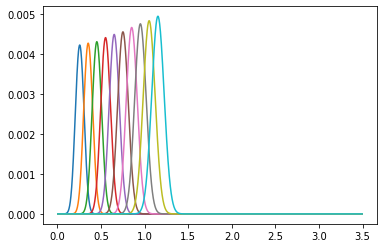

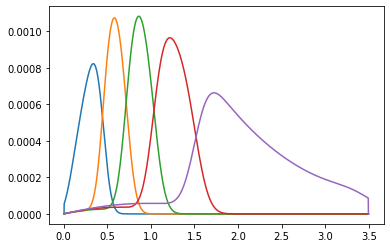

In [34]:
# Plot to make sure it looks okay:

plt.figure()
for i in range(0,10):
    plt.plot(z_cl, kernels_cl_tot[i])
plt.show()   

plt.figure()
for i in range(0,5):
    plt.plot(z_s, kernels_s_tot[i])
plt.show() 

In [42]:
# Now save to files

kernels_cl_arr = np.column_stack((z_cl, chi_cl, np.asarray(kernels_cl_tot).T))
kernels_s_arr = np.column_stack((z_s, chi_s, np.asarray(kernels_s_tot).T))

header_cl='z,  chi (Mpc),  kernels 1-10'
header_src='z,  chi (Mpc),  kernels 1-5'

np.savetxt('./NumberCountKernels.dat', kernels_cl_arr, header = header_cl)
np.savetxt('./LensingKernels.dat', kernels_s_arr, header = header_src)